In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import seaborn as sns

C:\Users\user\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


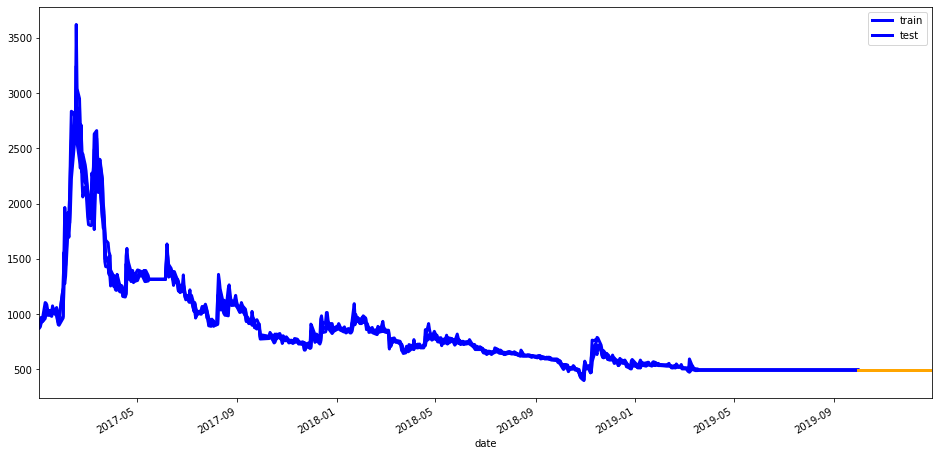

In [2]:
data = pd.read_csv("./data/df_final.csv")
data = data[data["code"] == 44180]
data = data[data.columns[1:6]]
data["date"] = pd.to_datetime(data["date"])
data = data.set_index("date")

split_date = pd.Timestamp("2019-09-30")
train = data.loc[:split_date, ["open", "high", "low", "close"]]
test = data.loc[split_date:, ["open", "high", "low", "close"]]

ax = train.plot(figsize=(16,8), color='b', linewidth=3)
test.plot(ax=ax, color='orange', linewidth=3)
plt.legend(['train', 'test'])
plt.show()

In [3]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

train_sc_df = pd.DataFrame(train_sc, columns=["open", "high", "low", "close"], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=["open", "high", "low", "close"], index=test.index)

# List
columns = ["open", "high", "low", "close"]

for col in columns : 
    for s in range(1, 13):
        train_sc_df['{} shift_-{}'.format(col,s)] = train_sc_df[col].shift(s)
        test_sc_df['{} shift_-{}'.format(col,s)] = test_sc_df[col].shift(s)
        
X_train = train_sc_df.dropna().drop(["open", "high", "low", "close"], axis=1)
y_train = train_sc_df.dropna()[["open", "high", "low", "close"]]["close"]

X_test = test_sc_df.dropna().drop(["open", "high", "low", "close"], axis=1)
y_test = test_sc_df.dropna()[["open", "high", "low", "close"]]["close"]

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

X_train_t = X_train.reshape(X_train.shape[0], 48, 1)
X_test_t = X_test.reshape(X_test.shape[0], 48, 1)

from numpy.random import seed
seed(1234)
from tensorflow import set_random_seed
set_random_seed(1234)

from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, Activation
K.clear_session() 
model = Sequential() # Sequeatial Model 
model.add(LSTM(20, input_shape=(48,1))) # (timestep, feature) 
model.add(Dense(1)) # output = 1 
model.compile(loss='mean_squared_error', optimizer='adam') 
model.summary()

C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20)                1760      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


Using TensorFlow backend.


In [4]:
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)
model.fit(X_train_t, y_train, epochs=150, batch_size=100, verbose=1, callbacks=[early_stop])

Epoch 1/150
659/659 [==============================] - 1s 1ms/step - loss: 0.0599
Epoch 2/150
659/659 [==============================] - 0s 247us/step - loss: 0.0330
Epoch 3/150
659/659 [==============================] - 0s 238us/step - loss: 0.0189
Epoch 4/150
659/659 [==============================] - 0s 238us/step - loss: 0.0153
Epoch 5/150
659/659 [==============================] - 0s 238us/step - loss: 0.0131
Epoch 6/150
659/659 [==============================] - 0s 236us/step - loss: 0.0096
Epoch 7/150
659/659 [==============================] - 0s 248us/step - loss: 0.0070
Epoch 8/150
659/659 [==============================] - 0s 238us/step - loss: 0.0051
Epoch 9/150
659/659 [==============================] - 0s 236us/step - loss: 0.0042
Epoch 10/150
659/659 [==============================] - 0s 236us/step - loss: 0.0041
Epoch 11/150
659/659 [==============================] - 0s 236us/step - loss: 0.0041
Epoch 12/150
659/659 [==============================] - 0s 235us/step - loss

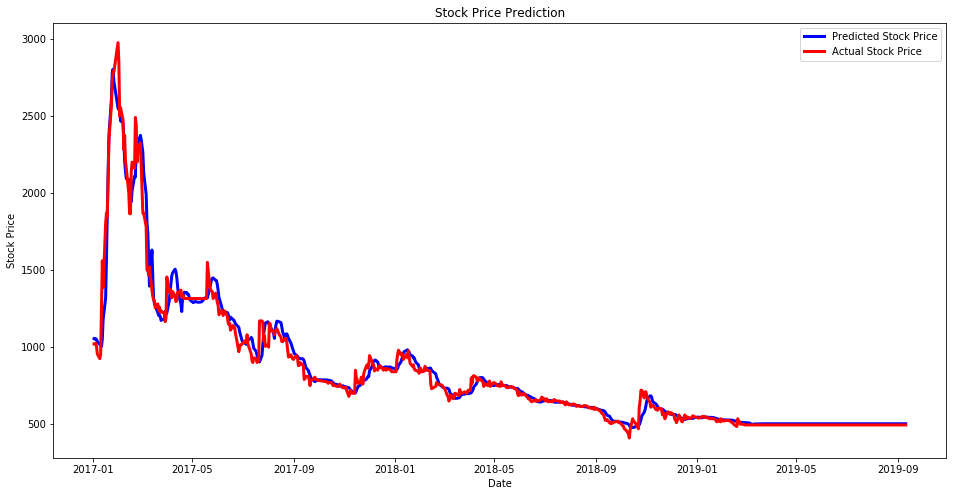

In [5]:
# Pred
y_pred = model.predict(X_train_t)
PRED = pd.DataFrame(y_pred)
PRED.columns = ["PRED"]

# Actual
REAL = pd.DataFrame(y_train)
REAL.columns = ["REAL"]

# Setting
RESULT = pd.concat([REAL,PRED], axis=1)
RESULT["date"] = train.index[12:]

# Set Index
RESULT = RESULT.set_index("date")

y_pred = model.predict(X_train_t)
y_pred = y_pred * (np.max(train["close"]) -  np.min(train["close"])) +  np.min(train["close"])
y_pred_df = pd.DataFrame(y_pred, columns=['prediction'], index=train.index[:-12])

y_train = y_train * (np.max(train["close"]) -  np.min(train["close"])) +  np.min(train["close"])
y_train_df = pd.DataFrame(y_train, columns=['actual_price'], index=train.index[:-12])

# plotting the results
fig = plt.figure(figsize=(16,8))
fig.patch.set_facecolor('xkcd:white')
plt.plot(y_pred_df["prediction"], color = 'blue', label = 'Predicted Stock Price', linewidth = 3)
plt.plot(y_train_df["actual_price"], color = 'red', label = 'Actual Stock Price', linewidth = 3)
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

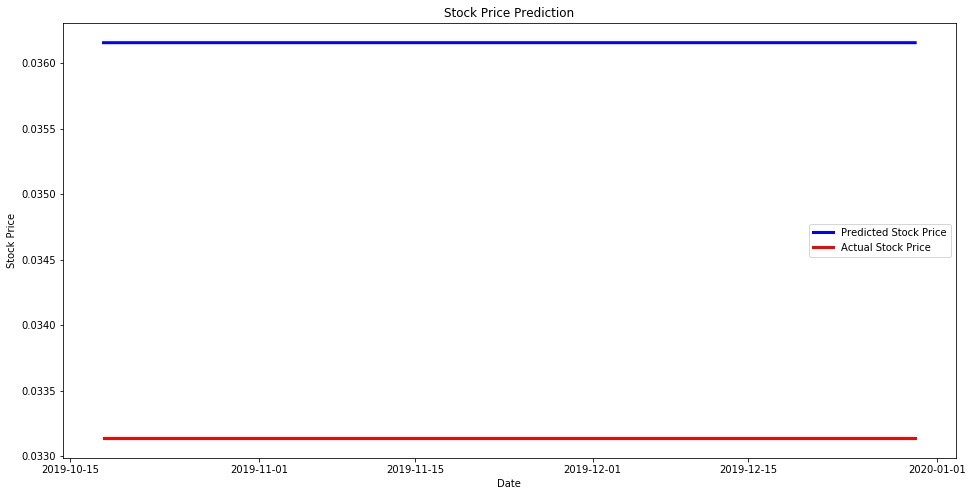

In [6]:
# Pred
y_pred = model.predict(X_test_t)
PRED = pd.DataFrame(y_pred)
PRED.columns = ["PRED"]

# Actual
REAL = pd.DataFrame(y_test)
REAL.columns = ["REAL"]

RESULT_TEST = pd.concat([REAL,PRED], axis=1)
RESULT_TEST["date"] = test.index[12:]

RESULT_TEST = RESULT_TEST.set_index("date")

y_pred = model.predict(X_test_t)
y_pred_df = pd.DataFrame(y_pred, columns=['prediction'], index=test.index[12:])

y_test_df = pd.DataFrame(y_test, columns=['actual_price'], index=test.index[12:])

# plotting the results
fig = plt.figure(figsize=(16,8))
fig.patch.set_facecolor('xkcd:white')
plt.plot(y_pred_df["prediction"], color = 'blue', label = 'Predicted Stock Price', linewidth = 3)
plt.plot(y_test_df["actual_price"], color = 'red', label = 'Actual Stock Price', linewidth = 3)
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [7]:
forecast_error = y_test.reshape(-1,1) - y_pred
SS, RMSE = 0, 0
for i in forecast_error : 
    SS = SS + i * i
    RMSE = SS / len(forecast_error)
print("Test DataSet's RMSE : {}" .format(float(RMSE**0.5)))

Test DataSet's RMSE : 0.003017497002795336
